# 자율주행 보조 시스템 만들기

## - 목차
1. 데이터셋 준비
2. 데이터 포맷 변경
3. 셋팅
4. 결과 시각화
5. 자율 주행 시스템

- 프로젝트 정리

## 1. 데이터셋 준비
- tensorflow_datasets에서 제공하는 KITTI 데이터셋.
- 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공.

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling kitti-train.tfrecord...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling kitti-validation.tfrecord...:   0%|          | 0/423 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling kitti-test.tfrecord...:   0%|          | 0/711 [00:00<?, ? examples/s]

Dataset kitti downloaded and prepared to /aiffel/aiffel/object_detection/data/kitti/3.2.0. Subsequent calls will reuse this data.
=3


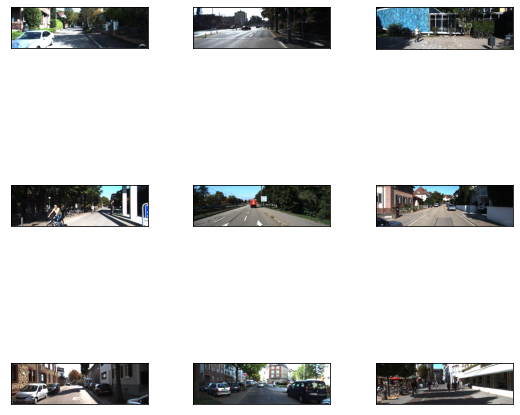

In [3]:
#다운로드 한 데이터셋 확인
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 1.75,  1.61, -2.05, -3.05,  2.89], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.36258668, 0.36391303, 0.50325334, 0.42301127],
       [0.46061334, 0.43028986, 0.51304   , 0.45037037],
       [0.49626666, 0.46033818, 0.56362665, 0.4914573 ],
       [0.26618665, 0.        , 0.5043733 , 0.21657005],
       [0.44850665, 0.35500807, 0.5190667 , 0.4144364 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.39, 1.52, 3.56],
       [1.34, 1.64, 4.57],
       [2.72, 2.03, 5.4 ],
       [1.53, 1.54, 4.35],
       [1.52, 1.41, 4.22]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-3.56,  1.81, 21.44],
       [-4.59,  2.07, 52.71],
       [-2.16,  1.76, 80.41],
       [-9.32,  1.82, 14.46],
       [-8.11,  2.01, 44.2 ]], dtype=float32)>, 'oc

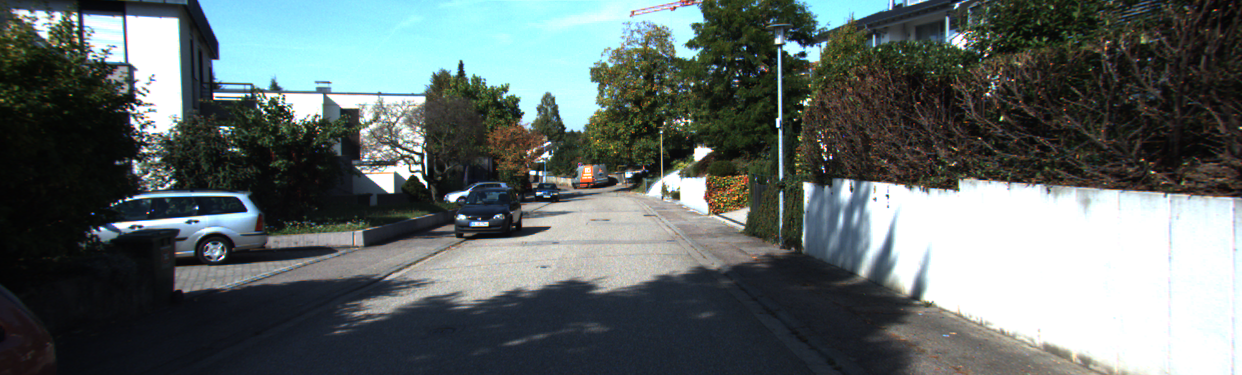

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) 
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(5, 4)
[451.97998 239.03    525.38    186.28   ]
[534.42 202.27 559.36 182.61]
[571.74    188.9     610.38995 163.64001]
[  0.   275.18 268.98 185.86]
[440.92    206.81    514.73    180.34999]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F860CBDE1D0>


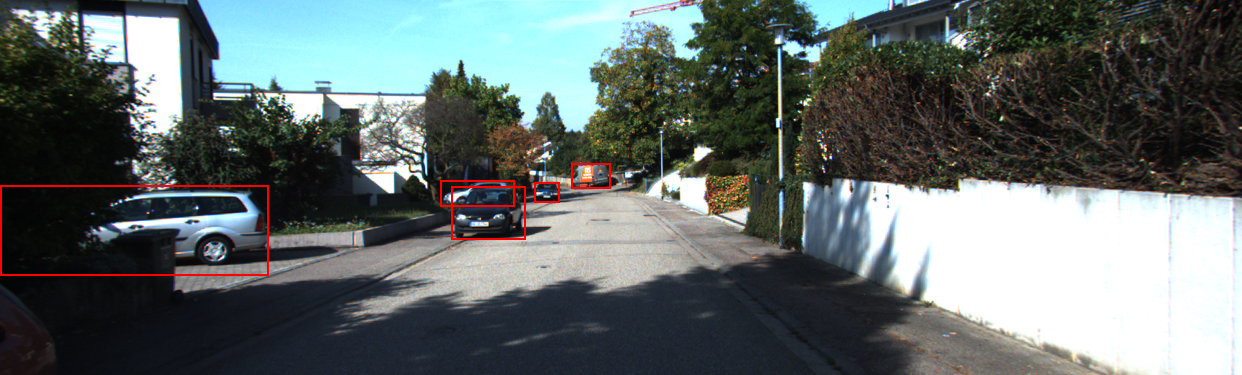

In [7]:
#바운딩박스 그리기
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    #바운딩박스 좌표
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    #바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 2. 데이터 포맷 변경
- Keras RetinaNet은 케라스(Keras) 라이브러리로 구현된 RetinaNet임.
- 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경해주는 방법사용.

### 클래스 및 바운딩 박스 정보 추출
- API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장.
- 한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성 후 csv 파일 생성.

In [8]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'


def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
        
    #Dataset의 claas를 확인하여 class에 따른 index를 확인.
    #class를 차와 사람으로 구별함.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    
    #dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        #tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        #한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [22:16<00:00,  4.75it/s]


In [9]:
#테스트데이터셋도 dataframe 생성
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:35<00:00,  4.58it/s]


## 클래스 맵핑
- 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 함.
- 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있음.

In [10]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


## 3. 셋팅

In [11]:
#RetinaNet 훈련
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-08 02:25:28.478079: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-08 02:25:28.478129: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-08 02:25:32.209334: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-08 02:25:32.217507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-08 02:25:32.217632: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 3.1736 - regression_loss: 2.5638 - classification_loss: 0.6098
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 1404s 7s/step - loss: 3.1736 - regression_loss: 2.5638 - classification_loss: 0.6098
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 2.3499 - regression_loss: 2.0299 - classification_loss: 0.3199
Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
195/195 [==============================] - 1389s 7s/step - loss: 2.3499 - regression_loss: 2.0299 - classification_loss: 0.3199
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 2.0877 - regression_loss: 1.8038 - classification_loss: 0.2840
Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
195/195 [==============================] - 1367s 7s/step - loss: 2.0877 - regression_loss: 1.8038 - classification_loss: 0.2840
Epoch 4/10
195/195 [=================

In [12]:
#학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-08 06:24:05.354119: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-08 06:24:05.354168: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-08 06:24:07.634418: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-08 06:24:07.642618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-08 06:24:07.642741: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

## 4. 결과 시각화

In [13]:
%matplotlib inline

#automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2


import keras
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

[198.48898 136.6138  358.3755  231.37973]
[595.53613 175.8337  626.65533 204.98633]
[376.7976  185.57869 416.53455 209.43404]
[530.47296 159.56865 563.9503  190.54767]
[442.7725  173.98503 472.6105  197.12944]


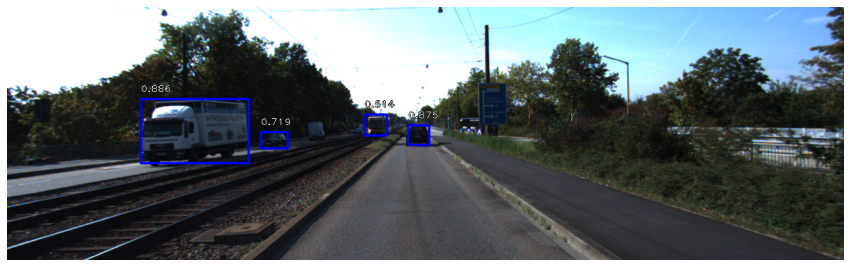

In [14]:
#결과 확인 함수
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

#inference_on_image 함수
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    #copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    #preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    #process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    #correct for image scale
    boxes /= scale

    #display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[776.1008  146.13824 836.7332  313.59332]
[795.36084 155.34859 848.0345  296.09973]


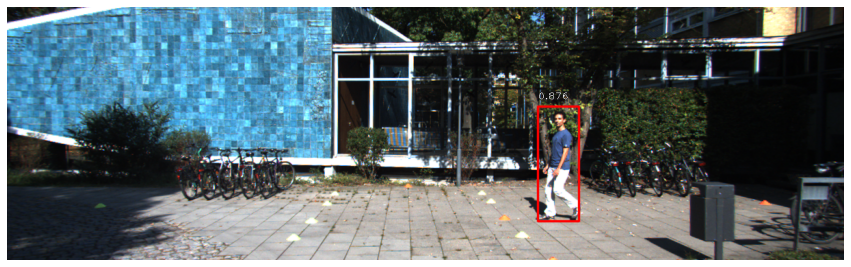

In [15]:
#다른 이미지도 확인
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

## 5. 자율주행 시스템

In [46]:
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), 
        1: (255, 0, 0)  
    }

    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    boxes /= scale

    #시각화
    if visualize:
        result = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.65:  #0.65 이하는 제외
                break
            b = box.astype(int)
            w = b[2]-b[0]
            h = b[3]-b[1]
            
            if w >= size_limit or h >= size_limit or label == 1:
                result = 'Stop'
            else:
                result = 'Go'
            
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        
        return result

[776.1008  146.13824 836.7332  313.59332]
[795.36084 155.34859 848.0345  296.09973]


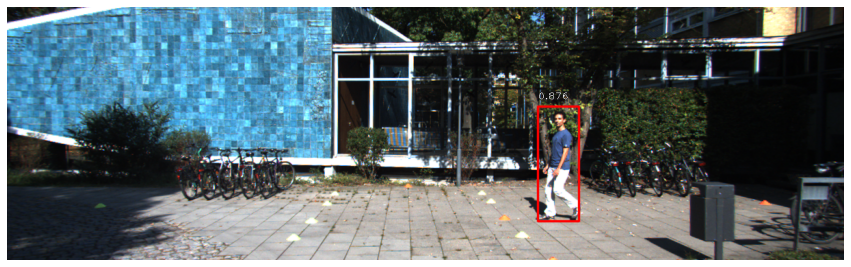

Stop


In [47]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

print(self_drive_assist(model=model, img_path=img_path))

## 5.1 자율주행 시스템 평가하기

In [48]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(model=model, img_path=image_path)
        print(image_file)
        print(f'prediction: {pred}, answer: {answer}\n')
        if pred == answer:
            score += 10
    print(f"결과: {score}점입니다.")

[776.1008  146.13824 836.7332  313.59332]
[795.36084 155.34859 848.0345  296.09973]


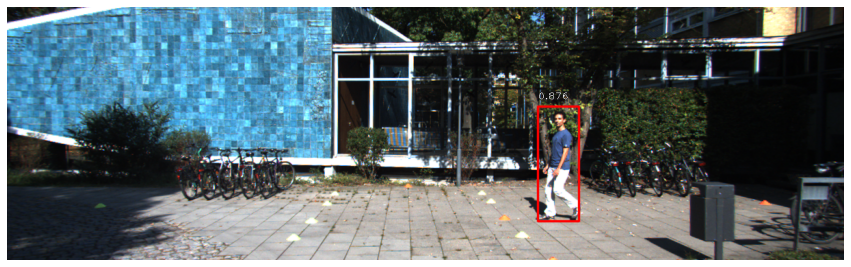

test_set/stop_1.png
prediction: Stop, answer: Stop

[426.62582 161.11992 488.7336  337.66516]
[445.32797 168.03278 496.58524 294.31927]


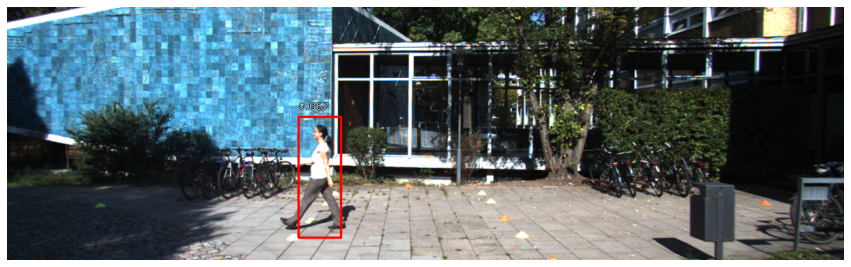

test_set/stop_2.png
prediction: Stop, answer: Stop

[ 13.704327 204.68092  315.00122  369.12827 ]
[756.3465  162.21828 878.2963  208.15363]
[ 992.9322   148.06296 1029.006    211.30438]
[1005.70795  145.28508 1037.784    214.27284]


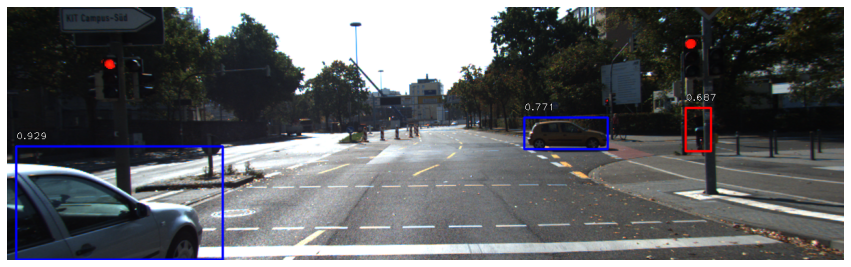

test_set/stop_3.png
prediction: Stop, answer: Stop

[ 723.64294    86.570755 1078.6075    359.73343 ]
[656.5363  143.3304  738.29065 222.59006]
[ 20.496153 159.49937  350.36414  313.35748 ]
[432.84708 162.67123 551.4986  207.6394 ]
[355.07944 174.63318 473.47342 220.5636 ]
[392.35535 168.7172  522.2653  213.1251 ]


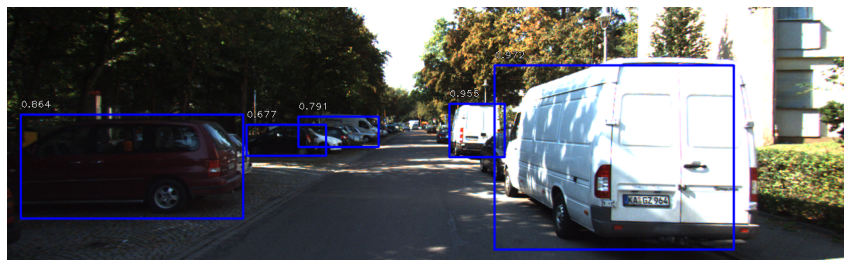

test_set/stop_4.png
prediction: Go, answer: Stop

[ 893.8152   175.21497 1241.0684   373.6249 ]
[569.8677  181.76309 615.45886 213.67029]
[698.04553 140.0189  769.5419  210.76671]
[735.6914  166.31758 861.9599  252.29333]
[702.6426  145.01202 806.24274 224.4063 ]


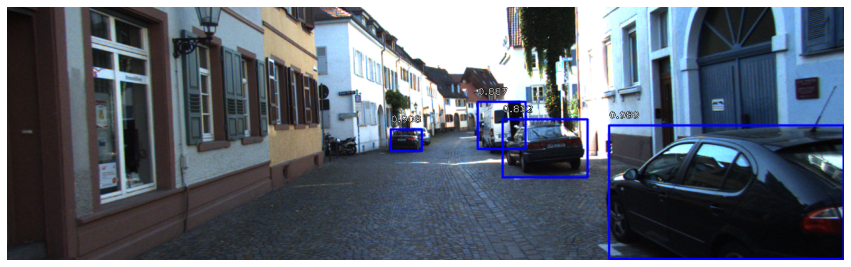

test_set/stop_5.png
prediction: Go, answer: Stop

[198.48898 136.6138  358.3755  231.37973]
[595.53613 175.8337  626.65533 204.98633]
[376.7976  185.57869 416.53455 209.43404]
[530.47296 159.56865 563.9503  190.54767]


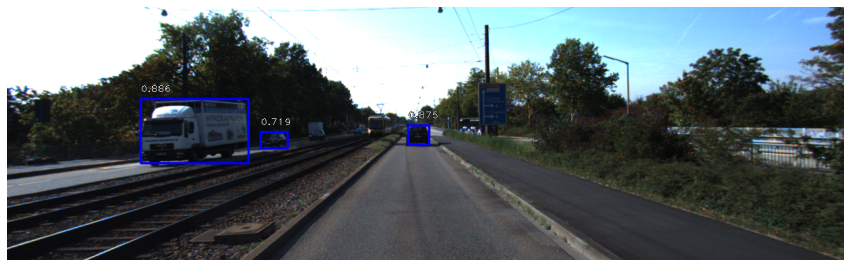

test_set/go_1.png
prediction: Go, answer: Go

[521.0003  180.32127 566.06854 213.81944]
[630.40845 177.20387 663.8009  208.47794]
[536.02234 178.68454 576.1801  206.1714 ]


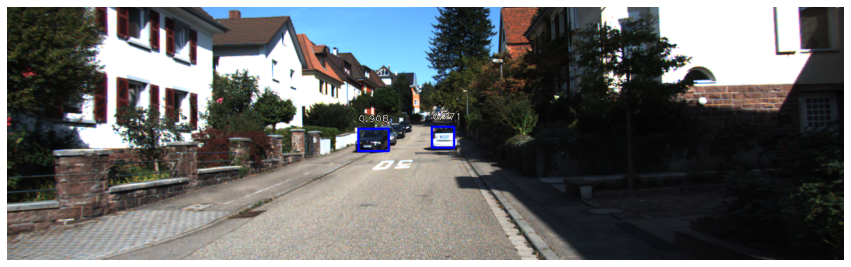

test_set/go_2.png
prediction: Go, answer: Go

[822.4459  151.31638 878.5163  174.89194]
[541.87506 167.38884 567.7695  190.02078]


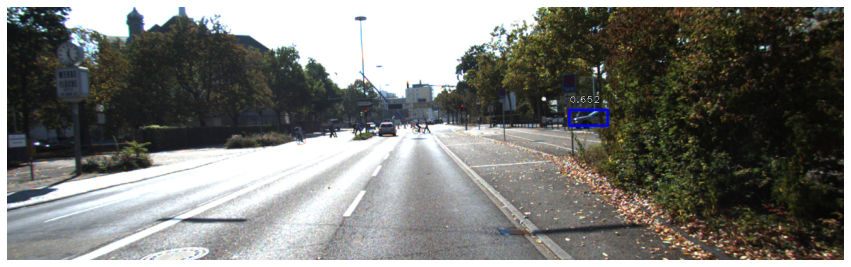

test_set/go_3.png
prediction: Go, answer: Go

[695.987   178.40541 788.4165  255.81694]
[705.36554 155.8119  769.8551  243.29382]


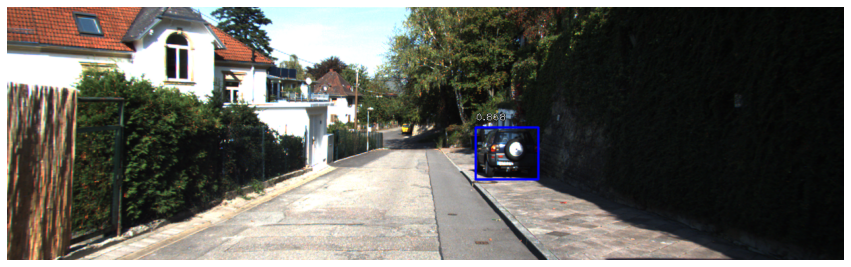

test_set/go_4.png
prediction: Go, answer: Go

[158.00232 183.55476 343.23453 252.8349 ]
[ 13.235855 190.52518  216.33925  302.60437 ]
[ 97.25927 188.35968 299.18286 261.9607 ]
[212.42587 171.92957 380.744   241.17877]


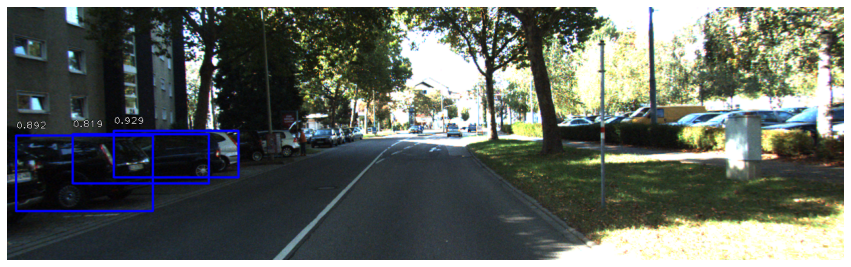

test_set/go_5.png
prediction: Go, answer: Go

결과: 80점입니다.


In [49]:
test_system(self_drive_assist)

---

# - 프로젝트 정리

| score threshold | 점수 |   
| :--: | :--: |   
| 0.3 | 70점 |   
| 0.4 | 80점 |   
| 0.45 | 80점 |   
| 0.5 | 80점 |   
| 0.6 | 80점 |   
| 0.65 | 80점 |    
| 0.7 | 70점 |    


- score threshold 값을 변경하면서 정확도를 높이고자 여러번 시도했는데 결과적으로 90점은 넘지 못했다.   
- score threshold 값만 바꿀 것이 아니라 모델 학습 부분에서 다른 시도를 해 봐야하나 생각을 했지만 모델 학습 시간이 굉장히 오래 걸려서(2-3시간 넘게 걸린 듯...) 여러가지를 시도해 보지 못해서 아쉬웠다.